In [1]:
import torch as tc
tc.set_default_dtype(tc.float64)

In [2]:
import numpy as np
import dCl
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import time

%load_ext autoreload
%autoreload 1
%aimport dCl

In [3]:
Nz = 2
zlist = tc.linspace(0.4, 0.5, Nz)
dCl_obj = dCl.Cl_kSZ2_HI2(zlist)

l_list = tc.linspace(50, 200, 10)
pz_list = 10.**tc.linspace(-3,-1, 16)

params = []
for zindex in range(Nz):
    for l in l_list:
        for pz in pz_list:
            params.append([zindex, l, pz])

params[0], params[-1]

Note: redshifts have been re-sorted (earliest first)


Note: redshifts have been re-sorted (earliest first)


([0, tensor(50.), tensor(0.0010)], [1, tensor(200.), tensor(0.1000)])

### Run the code to get dCl data

#### dCl : $\mathrm{kSZ}^2 \times \mathrm{HI}^2$

In [ ]:
def generate_l1_list():
    return tc.hstack([10.**tc.linspace(-4, 0, 5)[:-1], 
                      10.**tc.linspace(0, 1, 6)[:-1], 
                      tc.linspace(10, 300, 59)[:-1], 
                      10.**tc.linspace(np.log10(300), 3, 14)[:-1], 
                      10.**tc.linspace(3, 4, 10)])

def generate_lmax(l1, pz_chi):
    lmax = 2 * (l1 + pz_chi)
    lmax_cut = tc.ones_like(l1) * 150
    return tc.max(lmax, lmax_cut)

def generate_Ntheta(l1, pz_chi):
    return 300 + 3 * tc.tensor(l1 /50 / pz_chi**(0.1), dtype=tc.int32)
    # if pz > 0.1:
    #     return tc.ones_like(l1) * 300
    # else:
    #     return 0
    

def compute(zindex, l, pz, l1, lmax, Ntheta):
    res5 = dCl_obj.dCl_lm_Term5(zindex, l, l1, pz, l_max=lmax, N_theta=Ntheta)
    res6 = dCl_obj.dCl_lp_Term6(zindex, l, l1, pz, l_max=lmax, N_theta=Ntheta)
    return res5, res6

In [5]:
N_JOBS = 3
l1_list = generate_l1_list()
length100 = len(params) / 100

res = []
time0 = time.time()
for i, p in enumerate(params):
    zindex, l, pz = p
    chi = dCl_obj.chi_of_z[zindex]    
    lmax = generate_lmax(l1_list, pz*chi)
    Ntheta = generate_Ntheta(l1_list, pz*chi)

    res_p = Parallel(n_jobs=N_JOBS, prefer='threads')(delayed(compute)(zindex, l, pz, l1_list[l1_index], lmax[l1_index], Ntheta[l1_index]) 
                                                      for l1_index in range(len(l1_list)))
    
    time_i = time.time() - time0
    print(p, ', percent: {:.2f}%'.format((i+1)/length100), 
          ', average velocity: {:.2f}% per min'.format((i+1)/length100 * 60. / time_i), 
          '    ', end='\r')
    res.append(res_p)

res_w = tc.tensor(res).reshape([len(zlist), len(l_list), len(pz_list), len(l1_list), 2])
np.save('testdata.npy', res_w)

C:\Users\24121\AppData\Local\Temp\ipykernel_8060\981469656.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return 300 + 3 * tc.tensor(l1 /50 / pz_chi**(0.1), dtype=tc.int32)


#### dCl :  $\mathrm{HI}$ auto-correlation and $\mathrm{HI}^2$ auto-correlation

In [7]:
res = tc.empty([Nz, len(l_list)])

for zi in range(Nz):
    for li in range(len(l_list)):
        res[zi, li] = dCl_obj.dCl_HI2(zi=zi, l=l_list[li])

res.shape

torch.Size([2, 10])

In [8]:
np.save('testdata/dCl_HI2.npy', res)

#### dCl :  $\mathrm{kSZ}$ auto-correlation and $\mathrm{kSZ}^2$ auto-correlation

In [18]:
zmax, Nzksz = 12, 100
kSZ_obj = dCl.Cl_kSZ2(zmax=zmax, zmin=0.001, Nz=Nzksz, nonlinear=True)

Note: redshifts have been re-sorted (earliest first)


In [22]:
l_list = tc.tensor(np.geomspace(10, 1e5, 101))

Cl_kSZ = tc.empty_like(l_list)
for i, l in enumerate(l_list):
    Cl_kSZ[i] = kSZ_obj.Cl_kSZ(l, beam=True)
    print(i, l, '   ', end='\r')

np.save('testdata/Cl_kSZ.npy', Cl_kSZ)

CL_kSZ2 = kSZ_obj.Cl_kSZ2(l_list=l_list, Cl_kSZ=Cl_kSZ)

np.save('testdata/CL_kSZ2.npy', CL_kSZ2)

c:\Users\24121\Softwares\anaconda3\envs\yuwen\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\b\abs_e1nmgx0bk6\croot\pytorch-select_1725478824526\work\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Read in the data

#### Cross-correlation

In [25]:
Nz = 2
zlist = tc.linspace(0.4, 0.5, Nz)
l_list = tc.linspace(50, 200, 10)
pz_list = 10.**tc.linspace(-3,-1, 16)
l1_list = tc.hstack([10.**tc.linspace(-4, 0, 5)[:-1], 
                      10.**tc.linspace(0, 1, 6)[:-1], 
                      tc.linspace(10, 300, 59)[:-1], 
                      10.**tc.linspace(np.log10(300), 3, 14)[:-1], 
                      10.**tc.linspace(3, 4, 10)])

# The first factor 2 for double from integral over theta_1 (0,pi) -> (0,2pi)
# The second factor 2 for double from integral over p_z (pmin,pmax) -> (-pmax, pmax)
# The third factor (2pi)^(-5) for volume element from integral over l1 l2 pz
data_total = tc.tensor(np.load('testdata/Term5and6.npy')) * 2 * 2 / (2*tc.pi)**5

print(len(zlist), len(l_list), len(pz_list), len(l1_list), data_total.shape[-1])
print(data_total.shape)

2 10 16 90 2
torch.Size([2, 10, 16, 90, 2])


In [26]:
########################################################################
# Sum over term 5 and 6, and then integrate over l1
data_term5 = tc.trapz(data_total[..., 0], l1_list, dim=-1)
data_term6 = tc.trapz(data_total[..., 1], l1_list, dim=-1)
data_int_l1 = tc.trapz(data_total.sum(dim=-1), l1_list, dim=-1)

########################################################################
# Integrate over pz
data_int_pz = tc.trapz(data_int_l1, pz_list, dim=-1)

########################################################################
# Integrate over chi
Cl_cross = tc.trapz(data_int_pz.T * dCl_obj.F_kSZ**2 * dCl_obj.G_HI , dCl_obj.chi_of_z, dim=-1)

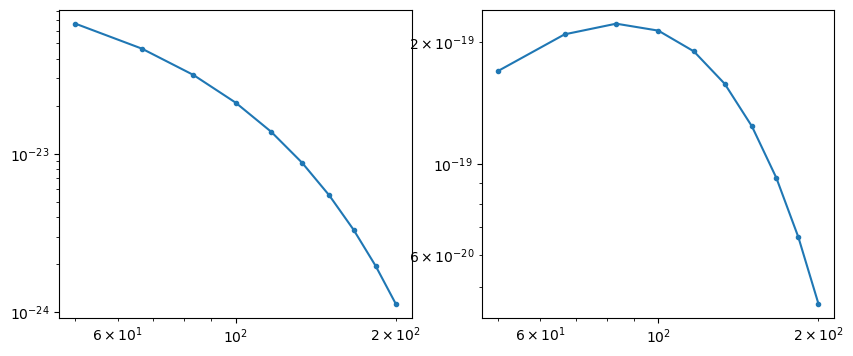

In [27]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(l_list, Cl_cross, '.-')
plt.xscale('log')
plt.yscale('log')

plt.subplot(1,2,2)
plt.plot(l_list, l_list * (l_list + 1) * Cl_cross, '.-')
plt.xscale('log')
plt.yscale('log')

plt.show()

#### HI square field auto-correlation

In [28]:
Nz = 2
zlist = tc.linspace(0.4, 0.5, Nz)
l_list = tc.linspace(50, 200, 10)

dCl_HI2 = tc.tensor(np.load('testdata/dCl_HI2.npy'))

# Integrate over chi
Cl_HI2 = tc.trapz(dCl_HI2.T * dCl_obj.G_HI_auto, dCl_obj.chi_of_z, dim=-1)

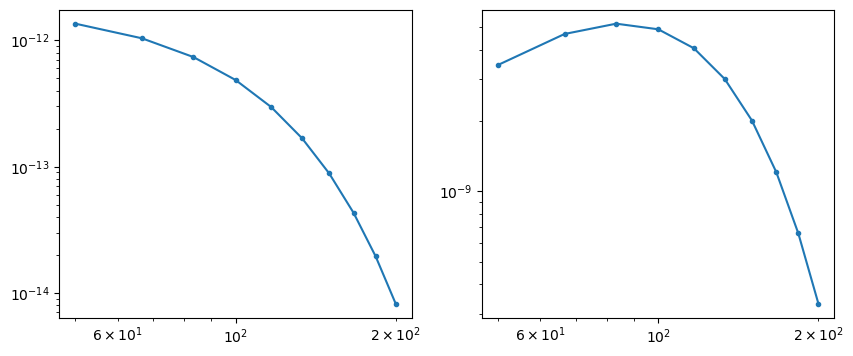

In [29]:
fig = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(l_list, Cl_HI2, '.-')
plt.xscale('log')
plt.yscale('log')

plt.subplot(1,2,2)
plt.plot(l_list, l_list * (l_list + 1) * Cl_HI2, '.-')
plt.xscale('log')
plt.yscale('log')

plt.show()

#### kSZ square field auto-correlation

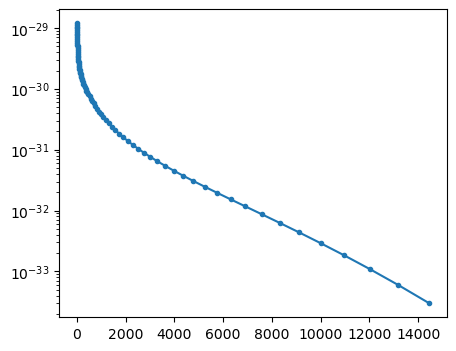

In [32]:
l_list_kSZ = tc.tensor(np.geomspace(10, 1e5, 101))

CL_kSZ2 = tc.tensor(np.load('testdata/CL_kSZ2.npy')) / (2*tc.pi)**2

fig = plt.figure(figsize=(5,4))
xi, xe = 0, 80
plt.plot(l_list_kSZ[xi:xe], CL_kSZ2[xi:xe], '.-')
plt.yscale('log')
plt.show()

#### SNR estimation

In [40]:
def torch_interp1d(x, y, x_new):

    indices = tc.searchsorted(x, x_new) - 1
    indices = tc.clamp(indices, 0, len(x) - 2)

    x0, x1 = x[indices], x[indices + 1]
    y0, y1 = y[indices], y[indices + 1]

    slope = (y1 - y0) / (x1 - x0)
    y_query = y0 + slope * (x_new - x0)
    
    return y_query

def loglog_torch_itp(x, y, x_new):
    return 10**torch_interp1d(tc.log10(x), tc.log10(y), tc.log10(x_new))

l_list = tc.linspace(50, 200, 10)
l_list_kSZ = tc.tensor(np.geomspace(10, 1e5, 101))
l50_200 = tc.arange(50, 200)

Cl_kSZ2_HI2  = loglog_torch_itp(l_list, Cl_cross, l50_200)
Cl_HI2_auto  = loglog_torch_itp(l_list, Cl_HI2, l50_200)
Cl_kSZ2_auto = loglog_torch_itp(l_list_kSZ, CL_kSZ2, l50_200)

SNR = (2 * l50_200 + 1) * Cl_kSZ2_HI2**2 / (Cl_kSZ2_HI2**2 + Cl_HI2_auto * Cl_kSZ2_auto)
SNR_cs = tc.cumsum(SNR,dim=0)

SNR.shape, SNR_cs.shape

(torch.Size([150]), torch.Size([150]))

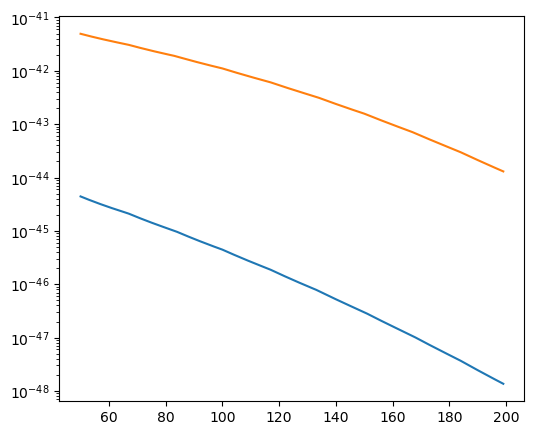

In [41]:
fig = plt.figure(figsize=(6,5))

plt.plot(l50_200, Cl_kSZ2_HI2**2)
plt.plot(l50_200, Cl_HI2_auto * Cl_kSZ2_auto)
plt.yscale('log')

plt.show()

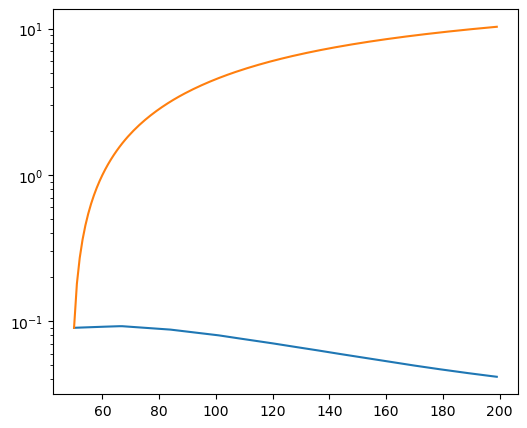

In [ ]:
fig = plt.figure(figsize=(6,5))

plt.plot(l50_200, SNR)
plt.plot(l50_200, SNR_cs)
plt.yscale('log')

plt.show()

### Plots

#### Cross-correlation

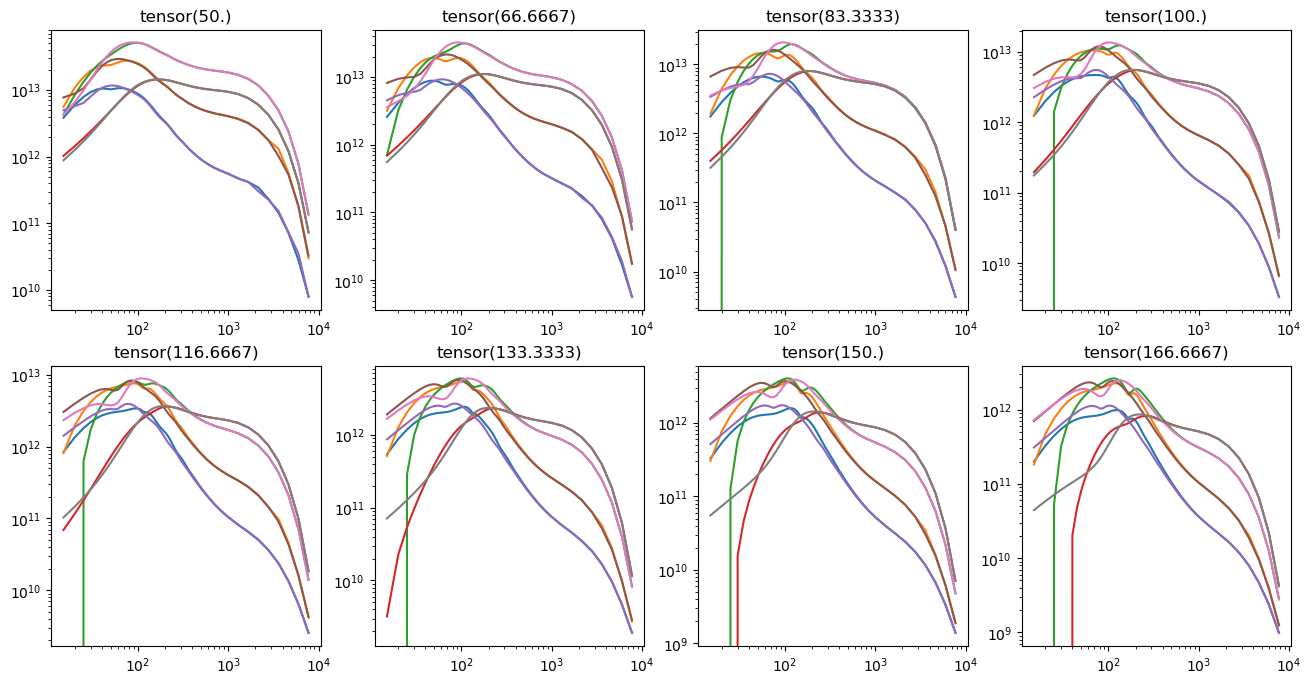

In [20]:
lindex = 3 # l=100
pz_index = 0 # pz=0.01
temr_index = 0
xscale = 'log'
yscale = 'log'

fig = plt.figure(figsize=(16,8))

xi, xe = 10, -1

for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.plot(l1_list[xi:xe], data_beam[i, ::4, xi:xe, 0].T)
    plt.plot(l1_list[xi:xe], data_beam[i, ::4, xi:xe, 1].T)
    # plt.plot(l1_list[xi:xe], data_beam[i, pz_index, xi:xe, 0])
    plt.xscale(xscale)
    plt.yscale(yscale)
    # plt.xlim([1e-1, 1e3])
    # plt.ylim([1e13, 1e22])
    plt.title(str(l_list[i]))

for i in range(4):
    plt.subplot(2, 4, i+5)
    plt.plot(l1_list[xi:xe], data_beam[i+4, ::4, xi:xe,0].T)
    plt.plot(l1_list[xi:xe], data_beam[i+4, ::4, xi:xe, 1].T)
    # plt.plot(l1_list[xi:xe], data_beam[i+4, pz_index, xi:xe, 0])
    plt.xscale(xscale)
    plt.yscale(yscale)
    # plt.xlim([1e-1, 1e3])
    # plt.ylim([1e13, 1e22])
    plt.title(str(l_list[i+4]))

plt.show()

In [21]:
data_term5 = tc.trapz(data_total[..., 0], l1_list, dim=-1)
data_term6 = tc.trapz(data_total[..., 1], l1_list, dim=-1)
data_term_both = tc.trapz(data_total.sum(dim=-1), l1_list, dim=-1)

data_term5.shape, data_term_both.shape

(torch.Size([2, 10, 16]), torch.Size([2, 10, 16]))

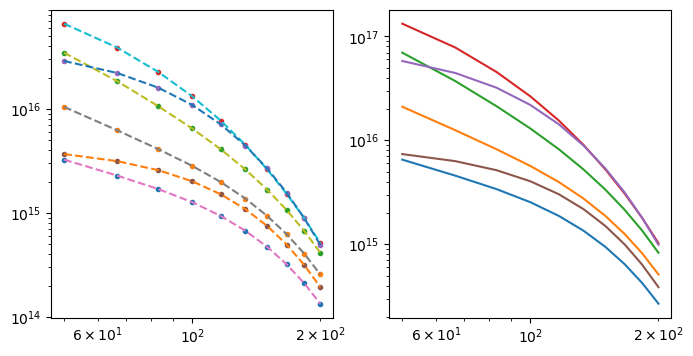

In [25]:
zindex = 0 # z=0.4
pz_index = 1 # pz=0.01
xscale = 'log'
yscale = 'log'

fig = plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(l_list, data_term5[zindex,:, ::3], '.')
plt.plot(l_list, data_term6[zindex,:, ::3], '--')
plt.xscale(xscale)
plt.yscale(yscale)

plt.subplot(1,2,2)
plt.plot(l_list, data_term_both[zindex,:, ::3])
plt.xscale(xscale)
plt.yscale(yscale)

plt.show()


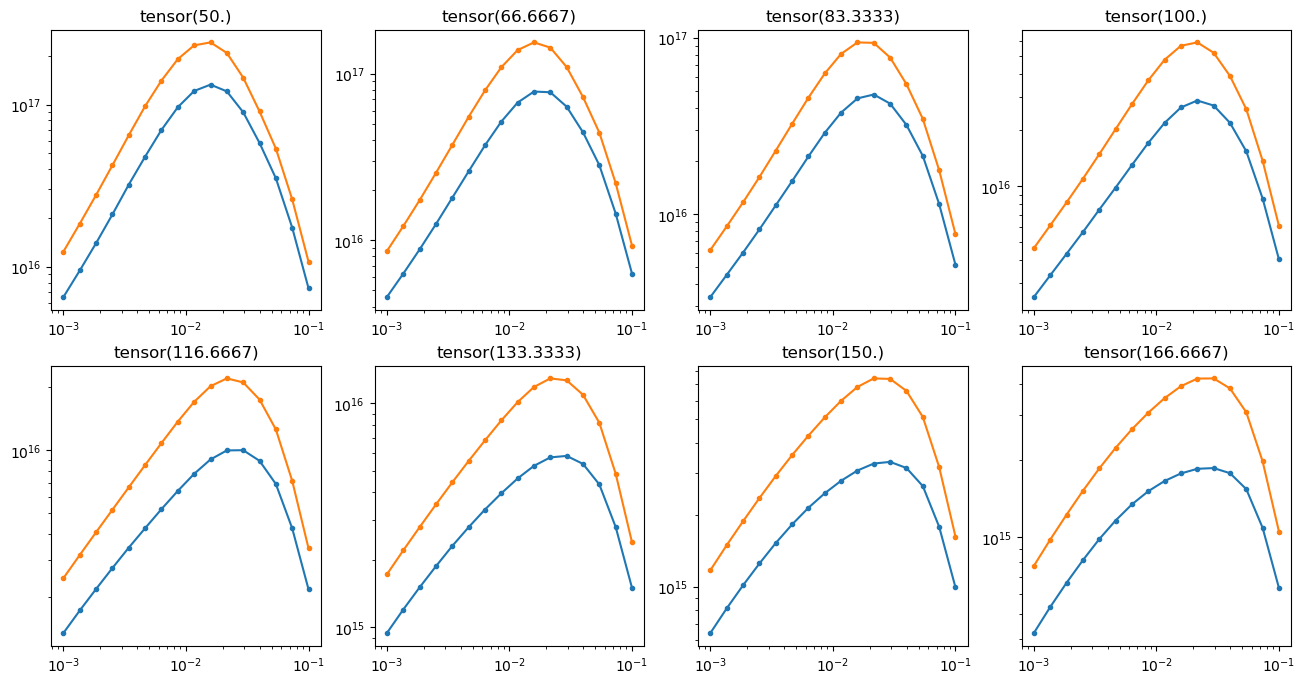

In [24]:
lindex = 0 # l=50
xscale = 'log'
yscale = 'log'

fig = plt.figure(figsize=(16,8))


for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.plot(pz_list, data_term_both[:, i].T, '.-')
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.title(str(l_list[i]))

for i in range(4):
    plt.subplot(2, 4, i+5)
    plt.plot(pz_list, data_term_both[:, i+5].T, '.-')
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.title(str(l_list[i+4]))

plt.show()